<a href="https://colab.research.google.com/github/hydradon/clever-challenge/blob/master/part3_predict_10th_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An approach using a shallow (3-layer) neural network to predict the 10th time step

## Results: Precision: 83.3%

In this notebook, I used the [DataFrame.shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) function to connect 2 consecutive events. The information of event `t-1` are used as features to predict the class of event `t+10`. 

Note that only features `f*(t-1)` and number of resources used by event `t-1` are used for prediction. I did not use the features `f*(t+n)` of future events.

I attempted using LSTM but its performance is slightly lower than that of the conventional neural network layer.

In [1]:
import pandas as pd

# Initial inspection shows that the timestamp column is Unix epoch time up to the Second granularity
dateparse = lambda timestamp: pd.to_datetime(timestamp, unit='s')

data = pd.read_csv("https://raw.githubusercontent.com/hydradon/clever-challenge/master/seq/sample.csv", 
                    index_col="timestamp",
                    date_parser=dateparse,
                    infer_datetime_format=True,
                    parse_dates=['timestamp'])
# View a sample of 10 rows
data.sample(5)

,event_id,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-11 13:16:50,821249,1,1,1,1,0.000000,17,14,168.000000,3,277.975023,1,7199,0,7144,9351,1,849.000000,0,576.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0
2018-04-10 08:56:04,819019,1,1,1,1,0.000000,7,1,0.000000,7,56.002812,1,1985,0,1985,9337,1,79.000000,0,79.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0
2018-02-16 17:08:23,816634,0,1,1,1,0.000000,1,1,106.000000,4,452.118414,1,33,0,7,9237,1,207.000000,0,4.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0
2018-07-19 15:10:18,822896,0,1,1,1,0.000000,7,1,103.000000,6,605.036412,1,1978,0,389,9277,1,1030.000000,0,947.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0
2018-05-17 14:25:55,820316,1,1,83,288,5.189409,960,970,750.256944,81,241.201967,288,72840,0,72822,9356,3,10499.666667,0,9393.0,0.0,0,0.0,3,0,0,0,0,0,0,0,0,0


In [2]:
# Looks like the following features only have constant 0 for all rows: f11, f16, f19, f22 - f30
const_col = ["f11", "f16", "f19"] + ["f{}".format(num) for num in range(22,31)]

# dropping these cols
data.drop(columns=const_col, inplace=True, errors='ignore')

In [3]:
# Read resource dataset
res = pd.read_csv("https://raw.githubusercontent.com/hydradon/clever-challenge/master/seq/res.csv")
res.sample(5)

,event_id,res_id
614288,817673,15458973
496562,815198,15574141
532932,815820,15545050
342365,812989,15551544
55372,811067,15380704


In [4]:
import numpy as np

def group_res_by_event(df):
    keys, values = df.sort_values('event_id').values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values, index[1:])
    df2 = pd.DataFrame({'event_id':ukeys, 'res_id':[list(a) for a in arrays]})
    return df2

res_grp = group_res_by_event(res)
res_grp

,event_id,res_id
0,811067,"[15325277, 15440054, 15440055, 15440056, 15440..."
1,811068,[15495262]
2,811069,"[15501813, 15501809, 15501812, 15501810, 15501..."
3,811070,"[15505228, 15505227, 15505225, 15505229, 15505..."
4,811071,"[15449230, 15449260, 15449270, 15449271, 15449..."
...,...,...
18303,829479,"[15475824, 15475827, 15475828, 15475830, 15475..."
18304,829480,"[15658697, 15658696]"
18305,829481,"[15666344, 15632590, 15548015, 15666343, 15632..."
18306,829482,"[15658538, 15695471, 15658424]"


In [5]:
# Merging 2 dataset
data_w_res = data.reset_index().merge(res_grp, on="event_id", how="left").set_index("timestamp")

# Fill event with no resource an empty resource list
data_w_res['res_id'] = data_w_res['res_id'].apply(lambda d: d if isinstance(d, list) else [])

# Calculate number of resources used
data_w_res['num_res'] = data_w_res['res_id'].apply(lambda d: len(d))
data_w_res.drop(columns=["res_id"], inplace=True)
data_w_res.head(5)

,event_id,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f17,f18,f20,f21,num_res
timestamp,,,,,,,,,,,,,,,,,,,,,,
2016-11-21 14:17:52,811067,1,9,16257,172188,10.287316,45344815,0,0.000000,1,0.000000,0,0,0,9230,0,0.0,0.0,0.0,0.0,0,171999
2016-12-01 16:23:01,811068,0,1,1,1,0.000000,2,1,3.000000,2,10.086910,1,0,0,9231,0,0.0,0.0,0.0,0.0,0,1
2016-12-02 09:14:02,811069,1,7,1731,10212,7.460379,2000330,84524,157.627693,1,2.579979,2442,172188,172076,9230,0,0.0,0.0,0.0,0.0,0,10202
2016-12-02 10:18:05,811070,0,1,4,12,1.665603,353,0,0.000000,1,0.000000,0,0,0,9232,0,0.0,0.0,0.0,0.0,0,12
2016-12-02 10:18:39,811071,0,2,4,22,0.919741,6263,4346,684.409091,2,10.341428,21,12,0,9232,0,0.0,0.0,0.0,0.0,0,22


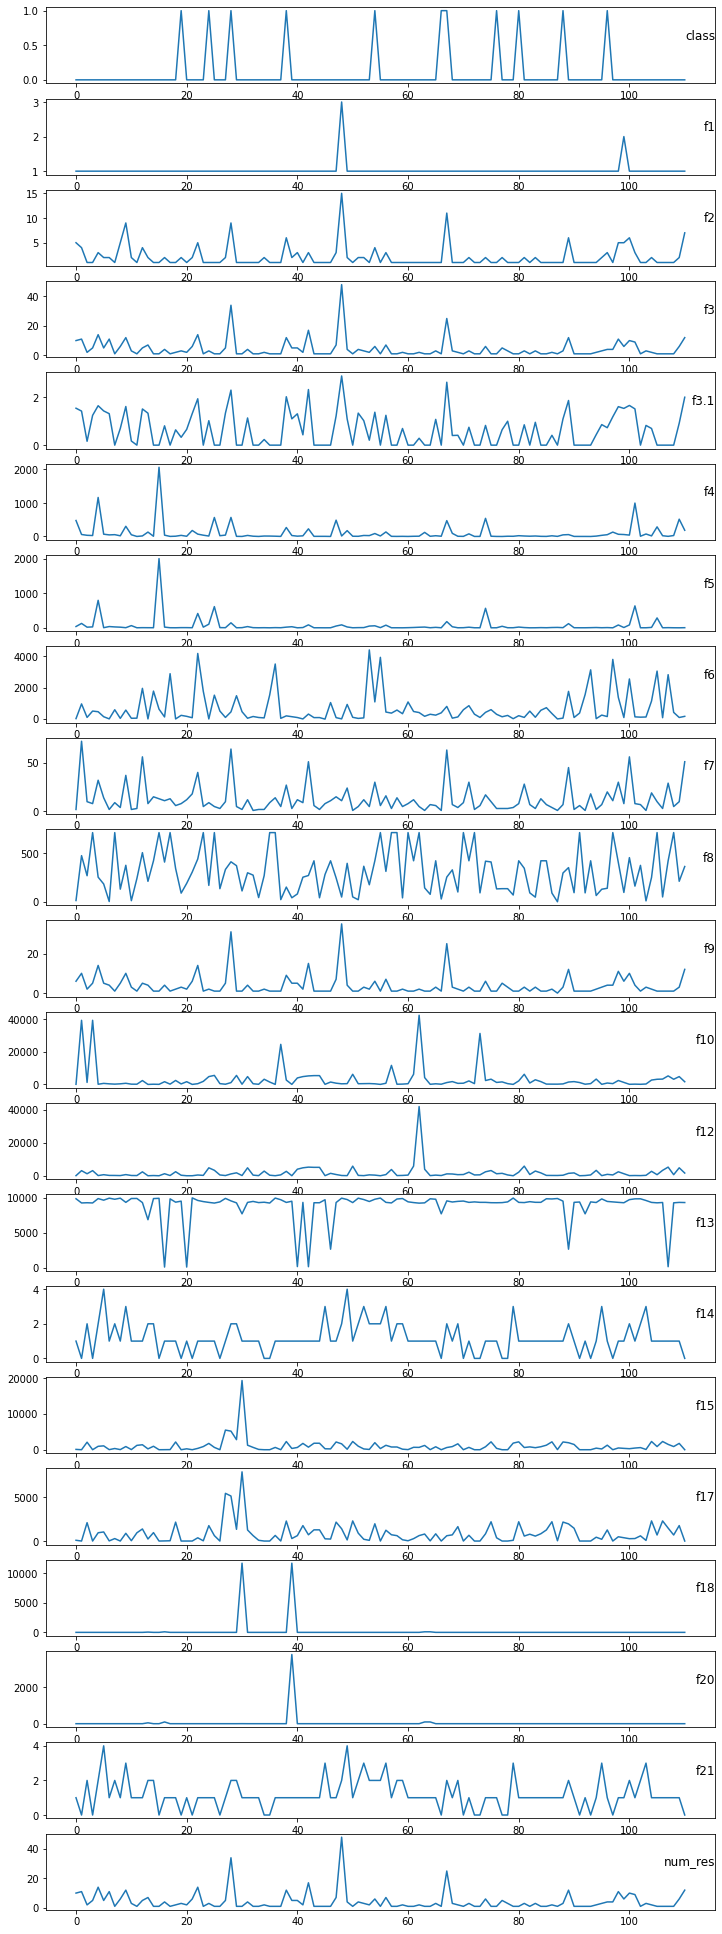

In [6]:
import matplotlib.pyplot as plt

# visualize class and features over a day (31st Oct 2018)
values = data_w_res.loc['2018-10-31 00:00:00':'2018-10-31 23:59:59'].values
# specify columns to plot
groups = list(range(1, 22))
i = 1
# plot each column
plt.rcParams["figure.figsize"] = 12,35
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data_w_res.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [7]:
data_w_res.drop(columns=["event_id"], inplace=True, errors='ignore')
data_w_res["time_stamp"] = data_w_res.index

In [8]:
data_w_res.head()

,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f17,f18,f20,f21,num_res,time_stamp
timestamp,,,,,,,,,,,,,,,,,,,,,,
2016-11-21 14:17:52,1,9,16257,172188,10.287316,45344815,0,0.000000,1,0.000000,0,0,0,9230,0,0.0,0.0,0.0,0.0,0,171999,2016-11-21 14:17:52
2016-12-01 16:23:01,0,1,1,1,0.000000,2,1,3.000000,2,10.086910,1,0,0,9231,0,0.0,0.0,0.0,0.0,0,1,2016-12-01 16:23:01
2016-12-02 09:14:02,1,7,1731,10212,7.460379,2000330,84524,157.627693,1,2.579979,2442,172188,172076,9230,0,0.0,0.0,0.0,0.0,0,10202,2016-12-02 09:14:02
2016-12-02 10:18:05,0,1,4,12,1.665603,353,0,0.000000,1,0.000000,0,0,0,9232,0,0.0,0.0,0.0,0.0,0,12,2016-12-02 10:18:05
2016-12-02 10:18:39,0,2,4,22,0.919741,6263,4346,684.409091,2,10.341428,21,12,0,9232,0,0.0,0.0,0.0,0.0,0,22,2016-12-02 10:18:39


## Preparing data for training

In summary, I am using all features and class of event at `t-1` to predict the class of future events.

Note that in this notebook, I did not use features of future events for prediction

In [9]:
# Scaling all features into the [0, 1] range
# Encoding the class column

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

cur_data = data_w_res.copy()
encoder = LabelEncoder()
cur_data["class"] = encoder.fit_transform(cur_data["class"])

# scale feature columns
ft_cols = ['f1', 'f2', 'f3', 'f3.1', 'f4', 'f5', 'f6', 'f7',
            'f8', 'f9', 'f10', 'f12', 'f13', 'f14', 'f15', 
            'f17', 'f18', 'f20','f21', 'num_res'] # 20 features

# ensure all data is float
cur_data[ft_cols] = cur_data[ft_cols].astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
cur_data[ft_cols] = scaler.fit_transform(cur_data[ft_cols])

In [10]:
cur_data.head()

,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f17,f18,f20,f21,num_res,time_stamp
timestamp,,,,,,,,,,,,,,,,,,,,,,
2016-11-21 14:17:52,1,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.000000e+00,0.005420,0.006135,0.000000,0.000000,0.000000,0.000000,0.924543,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,2016-11-21 14:17:52
2016-12-01 16:23:01,0,0.111111,0.000062,0.000006,0.000000,4.410647e-08,2.660611e-07,0.005534,0.012270,0.014108,0.000062,0.000000,0.000000,0.924644,0.0,0.0,0.0,0.0,0.0,0.0,0.000006,2016-12-01 16:23:01
2016-12-02 09:14:02,1,0.777778,0.106477,0.059307,0.725202,4.411375e-02,2.248855e-02,0.011436,0.006135,0.003608,0.151724,0.828237,0.835616,0.924543,0.0,0.0,0.0,0.0,0.0,0.0,0.059314,2016-12-02 09:14:02
2016-12-02 10:18:05,0,0.111111,0.000246,0.000070,0.161908,7.784793e-06,0.000000e+00,0.005420,0.006135,0.000000,0.000000,0.000000,0.000000,0.924744,0.0,0.0,0.0,0.0,0.0,0.0,0.000070,2016-12-02 10:18:05
2016-12-02 10:18:39,0,0.222222,0.000246,0.000128,0.089405,1.381194e-04,1.156302e-03,0.031541,0.012270,0.014464,0.001305,0.000058,0.000000,0.924744,0.0,0.0,0.0,0.0,0.0,0.0,0.000128,2016-12-02 10:18:39


In [18]:
def get_lagged_data(dataframe, n_in=1, n_out=1, dropnan=True):
    data = dataframe.values
    df = pd.DataFrame(data, columns=dataframe.columns)
    cols, names = list(), list()

	# Processing the input sequence (t-n, ... t-1) slices
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in dataframe.columns]

	# Processing the output sequence (t, t+1, ... t+n) slices
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(j)) for j in dataframe.columns]
        else:
            names += [('{}(t+{})'.format(j, i)) for j in dataframe.columns]
	
    # Concatenate all time lagged dataframe slices
    final = pd.concat(cols, axis=1)
    final.columns = names

	# drop rows with NaN values, because we shift columns up and down, 
    # some NaN values will be padded at either ends of the dataframe.
    if dropnan:
        final.dropna(inplace=True)
    return final

## Mapping current features (t-1) with the next 10 time steps (t, t+1,..., t+9)

In [101]:
data_shifted = get_lagged_data(cur_data, n_in=1, n_out=10)
print(data_shifted.shape) # Should be 1 row less than before processing due to shifting by 1
data_shifted.columns

(18407, 242)


Index(['class(t-1)', 'f1(t-1)', 'f2(t-1)', 'f3(t-1)', 'f3.1(t-1)', 'f4(t-1)',
       'f5(t-1)', 'f6(t-1)', 'f7(t-1)', 'f8(t-1)',
       ...
       'f12(t+9)', 'f13(t+9)', 'f14(t+9)', 'f15(t+9)', 'f17(t+9)', 'f18(t+9)',
       'f20(t+9)', 'f21(t+9)', 'num_res(t+9)', 'time_stamp(t+9)'],
      dtype='object', length=242)

In [102]:
feature_cols = [col for col in data_shifted.columns if "(t-1)" in col and 'time_stamp' not in col]
feature_cols

['class(t-1)',
 'f1(t-1)',
 'f2(t-1)',
 'f3(t-1)',
 'f3.1(t-1)',
 'f4(t-1)',
 'f5(t-1)',
 'f6(t-1)',
 'f7(t-1)',
 'f8(t-1)',
 'f9(t-1)',
 'f10(t-1)',
 'f12(t-1)',
 'f13(t-1)',
 'f14(t-1)',
 'f15(t-1)',
 'f17(t-1)',
 'f18(t-1)',
 'f20(t-1)',
 'f21(t-1)',
 'num_res(t-1)']

In [103]:
output_cols = [col for col in data_shifted.columns if "class" in col and 'class(t-1)' not in col]
output_cols

['class(t)',
 'class(t+1)',
 'class(t+2)',
 'class(t+3)',
 'class(t+4)',
 'class(t+5)',
 'class(t+6)',
 'class(t+7)',
 'class(t+8)',
 'class(t+9)']

## Predicting the 10th event from now

Similar approach can be used to predict different number of time steps

In [104]:
X = data_shifted[feature_cols]
Y = data_shifted['class(t+9)'] # 10 steps from now

In [105]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state=0)
train_X, train_y = train_X.astype('float32'), train_y.astype('float32')
test_X, test_y = test_X.astype('float32'), test_y.astype('float32')

In [106]:
# reshape input to be 3D [samples, timesteps, features]
train_X_val = train_X.values
train_X_val = train_X_val.reshape((train_X_val.shape[0], train_X.shape[1])) # If using LSTM, need to add a dimension of 1 (timestep = 1) in between these 2 dimesions

test_X_val = test_X.values
test_X_val = test_X_val.reshape((test_X_val.shape[0], test_X_val.shape[1]))

# train_y_val = train_y.values.reshape(len(train_y))
# test_y_val = test_y.values.reshape(len(test_y))
train_y_val = train_y.values
test_y_val = test_y.values

print(train_X_val.shape, train_y_val.shape, test_X_val.shape, test_y_val.shape)
# print(type(train_X_val), type(train_y_val), type(test_X_val), type(test_y_val))

(14725, 21) (14725,) (3682, 21) (3682,)


## Building a shallow neural network

At first, I used LSTM as the first layer but that gave an accuracy of about 68%.

Structure: 
- 1 Dense layer with dropout (to reduce overfitting)
- 1 Hidden layer
- 1 output layer with sigmoid activation (for binary classification)

### Metrics I am tracking
- Precision

In [122]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.metrics import binary_accuracy
from keras.metrics import Precision
from keras.optimizers import Adam

np.random.seed(7)

model = Sequential()
# model.add(LSTM(100, 
#                input_shape=(train_X_val.shape[1], train_X_val.shape[2]), # Input: time step * number of features
#                activation='relu'))
model.add(Dense(128, 
               input_dim=train_X_val.shape[1],
               activation='relu')) 

model.add(Dropout(0.2))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.2))

# Output layer with binary Classification 0 or 1
model.add(Dense(1, activation='sigmoid')) 

# Specify a low learning rate
opt = Adam(learning_rate=3e-4)

# Compile
model.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=[Precision()]) # binary_crossentropy for binary categorical label (0, 1)

print(model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 128)               2816      
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 129       
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
from keras.callbacks import ModelCheckpoint
import os

# Fitting
history = model.fit(train_X_val, train_y_val,
                    epochs=10, batch_size=50,
                    validation_data=(test_X_val, test_y_val),
                    # callbacks=[cp_callback],
                    verbose=2, shuffle=False)

Epoch 1/10
295/295 - 1s - loss: 0.6901 - precision_14: 0.4430 - val_loss: 0.6882 - val_precision_14: 0.0000e+00
Epoch 2/10
295/295 - 1s - loss: 0.6889 - precision_14: 0.4706 - val_loss: 0.6884 - val_precision_14: 0.0000e+00
Epoch 3/10
295/295 - 1s - loss: 0.6886 - precision_14: 0.4656 - val_loss: 0.6882 - val_precision_14: 0.0000e+00
Epoch 4/10
295/295 - 1s - loss: 0.6885 - precision_14: 0.4688 - val_loss: 0.6884 - val_precision_14: 0.0000e+00
Epoch 5/10
295/295 - 1s - loss: 0.6884 - precision_14: 0.4884 - val_loss: 0.6881 - val_precision_14: 0.0000e+00
Epoch 6/10
295/295 - 1s - loss: 0.6878 - precision_14: 0.4747 - val_loss: 0.6883 - val_precision_14: 0.0000e+00
Epoch 7/10
295/295 - 1s - loss: 0.6877 - precision_14: 0.4505 - val_loss: 0.6882 - val_precision_14: 1.0000
Epoch 8/10
295/295 - 1s - loss: 0.6876 - precision_14: 0.5019 - val_loss: 0.6881 - val_precision_14: 0.6250
Epoch 9/10
295/295 - 1s - loss: 0.6875 - precision_14: 0.5183 - val_loss: 0.6880 - val_precision_14: 0.6667
Epoc

## Evaluate the model

I used precision on test dataset

In [127]:
# evaluate the keras model
_, precision = model.evaluate(test_X_val, test_y_val)
print('Precision: %.2f %%' % (precision*100)) 

116/116 [==============================] - 0s 2ms/step - loss: 0.6879 - precision_14: 0.8333
Precision: 83.33 %
